In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [ ]:
from tensorflow.keras.models import load_model
from keras.preprocessing import image

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [ ]:
print(f"Total number of images: {sum(class_counts.values())}")
print(f"Number of images in train: {sum(train_class_counts.values())}")
print(f"Number of images in test: {sum(test_class_counts.values())}")

Total number of images: 224
Number of images in train: 157
Number of images in test: 67


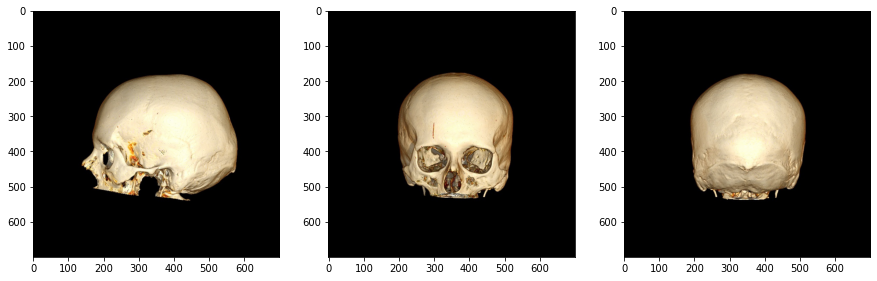

In [ ]:
img1 = mpimg.imread("/content/drive/MyDrive/sve_LP-bez augumentacije/train/F/122972329_F_61_LP.jpg")
img2 = mpimg.imread("/content/drive/MyDrive/sve_F-bez augumentacije/Train/F/122972329_F_61_F.jpg")
img3 = mpimg.imread("/content/drive/MyDrive/sve_O - bez augumentacija/Train/F/122972329_F_61_O.jpg")

# Plot the images side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)
plt.show()

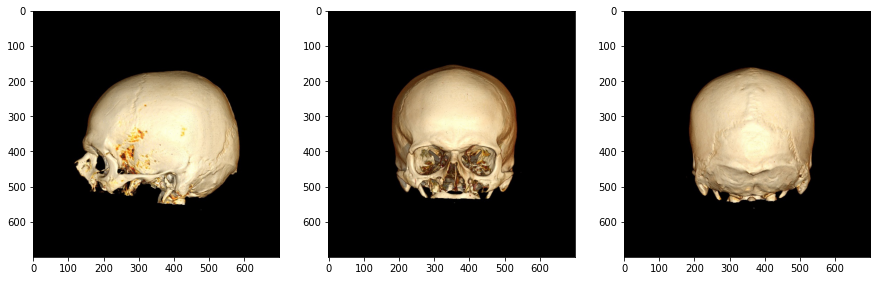

In [ ]:
img1 = mpimg.imread("/content/drive/MyDrive/sve_LP-bez augumentacije/train/M/159331096_M_62_LP.jpg")
img2 = mpimg.imread("/content/drive/MyDrive/sve_F-bez augumentacije/Train/M/159331096_M_62_F.jpg")
img3 = mpimg.imread("/content/drive/MyDrive/sve_O - bez augumentacija/Train/M/159331096_M_62_O.jpg")

# Plot the images side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)
plt.show()

# Loading models and making predictions

In [ ]:
model_LP = load_model('LP_fine_tune_87.h5')
model_F = load_model('F_fine_tune_90.h5')
model_O = load_model('O_fine_tune_87.h5')

In [ ]:
batch_size = 32

In [ ]:
def preprocess_data(batch_size, img_size, path):
  test_datagen = image.ImageDataGenerator(rescale = 1./255.)
  test_generator = test_datagen.flow_from_directory(path,
                                         target_size = img_size,
                                         class_mode = 'binary',
                                         batch_size=batch_size,
                                         shuffle= False)
  return test_generator

In [ ]:
test_LP =  preprocess_data(batch_size, img_size=[224,224], path = '/content/drive/MyDrive/sve_LP-bez augumentacije/test')

Found 67 images belonging to 2 classes.


In [ ]:
test_LP.class_indices

{'F': 0, 'M': 1}

In [ ]:
test_acc_LP = model_LP.evaluate(test_LP )
predictions_LP = model_LP.predict(test_LP )
predicted_classes_LP = np.where(predictions_LP < 0.5, 0, 1)
true_classes_LP = test_LP.classes
class_labels = list(test_LP.class_indices.keys())

3/3 [==============================] - 1s 114ms/step


In [ ]:
test_F =  preprocess_data(batch_size, img_size=[224,224], path = '/content/drive/MyDrive/sve_F-bez augumentacije/Test')

Found 67 images belonging to 2 classes.


In [ ]:
test_acc_F = model_F.evaluate(test_F)
predictions_F = model_F.predict(test_F)
predicted_classes_F = np.where(predictions_F < 0.5, 0, 1)
true_classes_F = test_F.classes

3/3 [==============================] - 3s 513ms/step


In [ ]:
test_O =  preprocess_data(batch_size, img_size=[224,224], path = '/content/drive/MyDrive/sve_O - bez augumentacija/Test')

Found 67 images belonging to 2 classes.


In [ ]:
test_acc_O = model_O.evaluate(test_O)
predictions_O = model_O.predict(test_O)
predicted_classes_O = np.where(predictions_O < 0.5, 0, 1)
true_classes_O = test_O.classes

3/3 [==============================] - 1s 167ms/step


# Combining models

## Majority voting

In [ ]:
# Initialize an empty list to store the predicted class labels
predicted_labels = []

# Loop through each sample in the dataset
for sample in range(len(predicted_classes_LP)):
    # Count the number of positive predictions across all outputs
    num_pos = predicted_classes_LP[sample] +  predicted_classes_F[sample] + predicted_classes_O[sample]

    # If the majority of the outputs predicted the positive class, assign the predicted label as 1, otherwise 0
    if num_pos > 1:
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

In [ ]:
report = metrics.classification_report(true_classes_LP,predicted_labels, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           F       0.94      0.91      0.92        33
           M       0.91      0.94      0.93        34

    accuracy                           0.93        67
   macro avg       0.93      0.93      0.93        67
weighted avg       0.93      0.93      0.93        67



In [ ]:
from sklearn import metrics
from tabulate import tabulate

def print_classification_report_table(true_labels, predicted_labels, class_labels):
    report = metrics.classification_report(true_labels, predicted_labels, target_names=class_labels, output_dict=True)

    # Convert the report dictionary to a table
    table = []
    for key, values in report.items():
        if key in class_labels:  # Include only class labels
            row = [key]
            row.extend([values['precision'], values['recall'], values['f1-score'], values['support']])
            table.append(row)

    # Add the average values to the table
    for avg in ['macro avg', 'weighted avg']:
        row = [avg]
        row.extend([report[avg]['precision'], report[avg]['recall'], report[avg]['f1-score'], report[avg]['support']])
        table.append(row)

    # Add accuracy to the table
    table.append(['accuracy', '', '', report['accuracy'], ''])

    headers = ['Class', 'Precision', 'Recall', 'F1-Score', 'Support']
    table_str = tabulate(table, headers, tablefmt='grid', floatfmt=".3f")

    print("Classification Report:\n")
    print(table_str)

# Usage
true_classes_LP = ['F'] * 33 + ['M'] * 34  # Replace with your actual labels
predicted_labels = ['F'] * 30 + ['M'] * 3 + ['F'] * 2 + ['M'] * 32  # Replace with your actual predictions
class_labels = ['F', 'M']  # Replace with your actual class labels

print_classification_report_table(true_classes_LP, predicted_labels, class_labels)


Classification Report:

+--------------+--------------------+--------------------+------------+-----------+
| Class        | Precision          | Recall             |   F1-Score | Support   |
+==============+====================+====================+============+===========+
| F            | 0.9375             | 0.9090909090909091 |      0.923 | 33        |
+--------------+--------------------+--------------------+------------+-----------+
| M            | 0.9142857142857143 | 0.9411764705882353 |      0.928 | 34        |
+--------------+--------------------+--------------------+------------+-----------+
| macro avg    | 0.9258928571428571 | 0.9251336898395721 |      0.925 | 67        |
+--------------+--------------------+--------------------+------------+-----------+
| weighted avg | 0.9257196162046909 | 0.9253731343283582 |      0.925 | 67        |
+--------------+--------------------+--------------------+------------+-----------+
| accuracy     |                    |               

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy manually
manual_accuracy = accuracy_score(true_classes_LP,predicted_labels)
print(f"Manual Accuracy: {manual_accuracy * 100:.2f}%")

Manual Accuracy: 92.54%


In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=true_classes_LP,y_pred= predicted_labels)

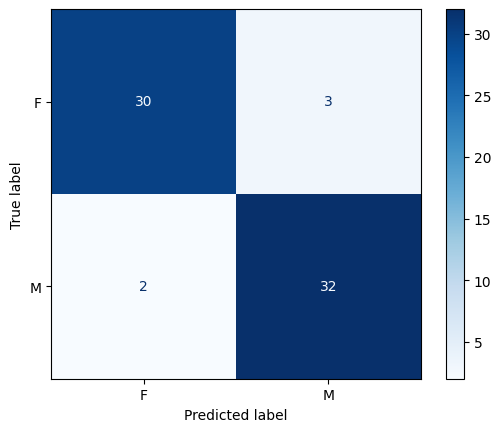

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()